# Understanding Positional Encoding in Transformers

This notebook demonstrates why we add positional encoding to input embeddings and visualizes the patterns.

In [12]:
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


class InputEmbeddings(nn.Module):
    def __init__(self, d_model: int, vocab_size: int):
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size

        self.embedding = nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        return self.embedding(x) * math.sqrt(self.d_model)
    




class PositionalEncoding(nn.Module):
    # seq_len is number of token in a sentence
    def __init__(self, d_model: int, seq_len: int, dropout: float):
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.dropout = nn.Dropout(dropout) # Percentage of Deactivated neurons

        # Create a matrix of shape (seq_len, d_model)
        positional_encoding = torch.zeros(seq_len, d_model)

        # Temp tensor to help Replicate the formula in the paper
        position = torch.arange(seq_len, dtype=torch.float).unsqueeze(1)
        even_index = torch.arange(0, d_model, 2)
        odd_index = torch.arange(1, d_model, 2)

        # assets/PE_LogTerm.png
        div_term = torch.exp(even_index * -math.log(10000)/d_model)

        # Formula from the paper section 3.5
        positional_encoding[:, even_index] += torch.sin(position * div_term)
        positional_encoding[:, odd_index] += torch.cos(position * div_term)

        # Add a batch dimension (1, seq_len, d_model)
        positional_encoding = positional_encoding.unsqueeze(0)

        self.register_buffer('positional_encoding', positional_encoding )

    def forward(self, x):
        x = x + (self.positional_encoding[:, :x.shape[1], :]).requires_grad_(False)
        return self.dropout(x)

## Why Positional Encoding?

Unlike RNNs, Transformers process all positions in parallel and have no inherent notion of sequence order. We need to inject position information into the model.

**Key insight**: We add positional encoding to embeddings because:
1. Addition preserves the original embedding information
2. The model can learn to attend to positional patterns
3. Sinusoidal functions allow the model to generalize to longer sequences

In [13]:
# Create a simple example
d_model = 512
seq_len = 100
vocab_size = 10000

# Initialize components
embedding_layer = InputEmbeddings(d_model, vocab_size)
pos_encoding = PositionalEncoding(d_model, seq_len, dropout=0.0)  # No dropout for visualization

## Example: How x and PE combine

Let's see what happens when we process a simple sequence:

In [14]:
# Create a sample input sequence
sample_tokens = torch.tensor([[42, 17, 99, 7, 123]])  # 5 token sequence
batch_size, seq_length = sample_tokens.shape

# Step 1: Get input embeddings (x)
x = embedding_layer(sample_tokens)
print(f"Input embeddings shape: {x.shape}")
print(f"Input embeddings (first 5 dims of first token): {x[0, 0, :5]}")

# Step 2: Extract the positional encoding that will be added
pe = pos_encoding.positional_encoding[:, :seq_length, :]
print(f"\nPositional encoding shape: {pe.shape}")
print(f"Positional encoding for position 0 (first 5 dims): {pe[0, 0, :5]}")

# Step 3: Add them together (what happens in forward pass)
x_with_pe = x + pe
print(f"\nCombined shape: {x_with_pe.shape}")
print(f"Combined values for first token (first 5 dims): {x_with_pe[0, 0, :5]}")

Input embeddings shape: torch.Size([1, 5, 512])
Input embeddings (first 5 dims of first token): tensor([18.6196, -5.7206, -1.1490,  7.9657, 10.8031], grad_fn=<SliceBackward0>)

Positional encoding shape: torch.Size([1, 5, 512])
Positional encoding for position 0 (first 5 dims): tensor([0., 1., 0., 1., 0.])

Combined shape: torch.Size([1, 5, 512])
Combined values for first token (first 5 dims): tensor([18.6196, -4.7206, -1.1490,  8.9657, 10.8031], grad_fn=<SliceBackward0>)


## Visualizing the Positional Encoding Pattern

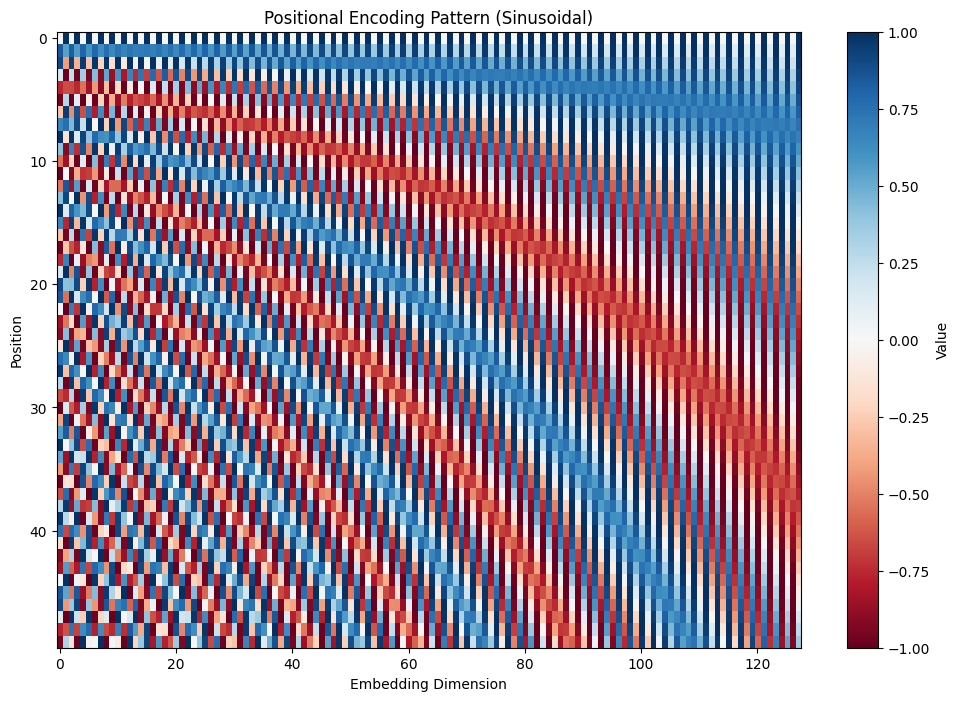

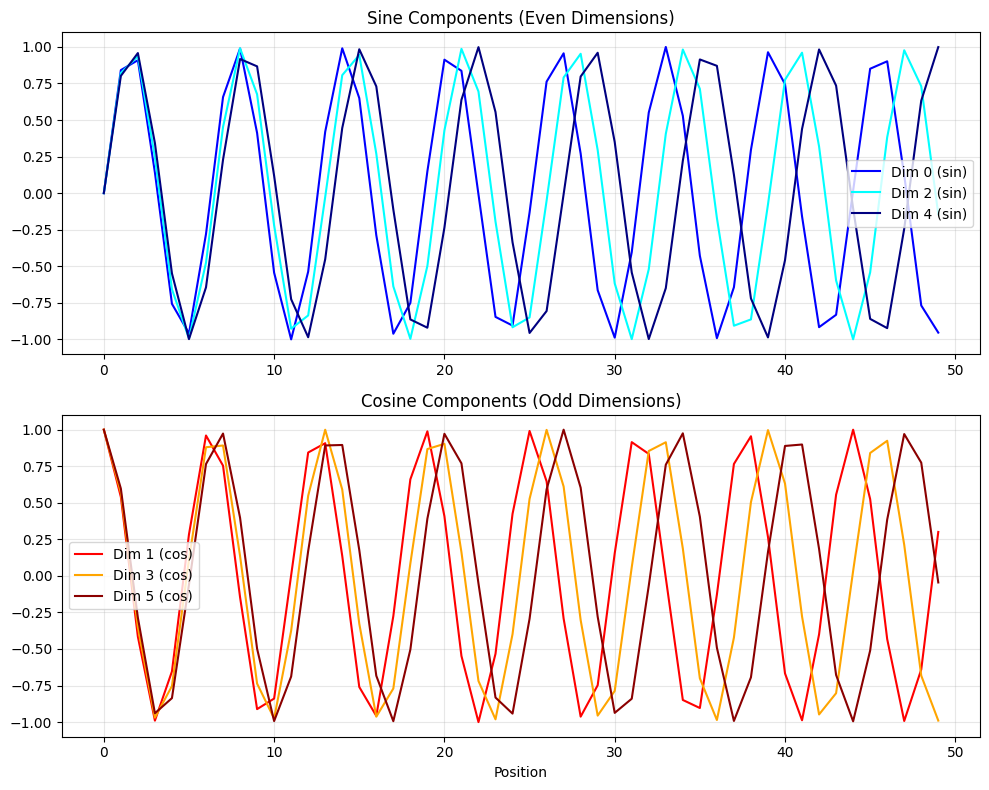

In [15]:
# Extract positional encoding matrix
pe_matrix = pos_encoding.positional_encoding[0, :50, :128].numpy()  # First 50 positions, 128 dimensions

# Create visualization
plt.figure(figsize=(12, 8))
plt.imshow(pe_matrix, cmap='RdBu', aspect='auto')
plt.colorbar(label='Value')
plt.xlabel('Embedding Dimension')
plt.ylabel('Position')
plt.title('Positional Encoding Pattern (Sinusoidal)')
plt.show()

# Show the sinusoidal pattern for specific dimensions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

positions = np.arange(50)
# Even dimensions use sine
ax1.plot(positions, pe_matrix[:, 0], label='Dim 0 (sin)', color='blue')
ax1.plot(positions, pe_matrix[:, 2], label='Dim 2 (sin)', color='cyan')
ax1.plot(positions, pe_matrix[:, 4], label='Dim 4 (sin)', color='navy')
ax1.set_title('Sine Components (Even Dimensions)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Odd dimensions use cosine
ax2.plot(positions, pe_matrix[:, 1], label='Dim 1 (cos)', color='red')
ax2.plot(positions, pe_matrix[:, 3], label='Dim 3 (cos)', color='orange')
ax2.plot(positions, pe_matrix[:, 5], label='Dim 5 (cos)', color='darkred')
ax2.set_title('Cosine Components (Odd Dimensions)')
ax2.set_xlabel('Position')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Why Add Instead of Concatenate?

1. **Efficiency**: Adding keeps the same dimensionality (d_model)
2. **Information Preservation**: The model can learn to separate position from content
3. **Flexibility**: The model decides how much to rely on positional information

In [16]:
# Demonstrate the effect of positional encoding on similar tokens at different positions
same_token = torch.tensor([[42, 42, 42, 42, 42]])  # Same token at 5 positions

# Get embeddings
x_same = embedding_layer(same_token)
x_with_pe_same = pos_encoding(x_same)

# Calculate cosine similarity between positions
cos_sim = nn.CosineSimilarity(dim=1)
similarities = torch.zeros(5, 5)

for i in range(5):
    for j in range(5):
        similarities[i, j] = cos_sim(x_with_pe_same[0, i:i+1, :], x_with_pe_same[0, j:j+1, :])

# Visualize similarity matrix
plt.figure(figsize=(8, 6))
sns.heatmap(similarities.numpy(), annot=True, fmt='.3f', cmap='YlOrRd', 
            xticklabels=range(5), yticklabels=range(5))
plt.title('Cosine Similarity Between Same Token at Different Positions')
plt.xlabel('Position')
plt.ylabel('Position')
plt.show()

print("Notice: Same tokens at different positions have different representations!")
print("This allows the model to distinguish between identical words at different positions.")

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

<Figure size 800x600 with 0 Axes>

## The requires_grad_(False) Detail

In the code: `x = x + (self.positional_encoding[:, :x.shape[1], :]).requires_grad_(False)`

We set `requires_grad_(False)` because:
1. Positional encodings are fixed sinusoidal patterns, not learned parameters
2. We don't want to update them during backpropagation
3. This saves memory and computation

In [17]:
# Verify that positional encoding doesn't require gradients
print(f"Positional encoding requires grad: {pos_encoding.positional_encoding.requires_grad}")
print(f"Input embeddings weight requires grad: {embedding_layer.embedding.weight.requires_grad}")

# Show the difference in trainable parameters
total_params = sum(p.numel() for p in pos_encoding.parameters())
trainable_params = sum(p.numel() for p in pos_encoding.parameters() if p.requires_grad)
print(f"\nPositional Encoding - Total params: {total_params}, Trainable: {trainable_params}")

total_params = sum(p.numel() for p in embedding_layer.parameters())
trainable_params = sum(p.numel() for p in embedding_layer.parameters() if p.requires_grad)
print(f"Input Embeddings - Total params: {total_params}, Trainable: {trainable_params}")

Positional encoding requires grad: False
Input embeddings weight requires grad: True

Positional Encoding - Total params: 0, Trainable: 0
Input Embeddings - Total params: 5120000, Trainable: 5120000
